# General EDA

The scope of this notebook is to explore the data and understand the relationships between different entities such as customers, transactions, and marketing campaigns

---
NOTE !!!: BEFORE ACCOUNTING ANY EFFECT, ENSURE THE EMAILS SENT ARE AFTER 2024
---

@roman

03 / 08 / 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import uuid
import datetime as dt

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import holidays

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

Importing plotly failed. Interactive plots will not work.


In [2]:
# see all the columns in the dataframe
pd.set_option('display.max_columns', None)

# max date
MAX_DATE = dt.datetime(2024, 7, 1)
MAX_DATE

datetime.datetime(2024, 7, 1, 0, 0)

---
# Data

## All

In [3]:
# read data
df_transactions = pd.read_csv("../data/Transactions.csv", header=0)
df_pricebook = pd.read_csv("../data/Pricebook.csv", header=0)
df_customers = pd.read_csv("../data/Customers.csv", header=0)
df_emails = pd.read_csv("../data/Emails.csv", header=0)
df_releases = pd.read_csv("../data/Releases.csv", header=0, sep="|")

## Transactions

In [4]:
# create uuid for each transaction based on CARD_MEMBERSHIPID & FECHA_TRANSACCION & FECHA_FUNCION
df_transactions['transaction_id'] = df_transactions.apply(
    lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, str(x['CARD_MEMBERSHIPID']) + '_' + str(x['FECHA_TRANSACCION']) + '_' + str(x['FECHA_FUNCION']))),
    axis=1
)

# look head
df_transactions.head()

,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,transaction_id
0,219,2024-06-13,2024-06-13,4f01380467cb31bd50a00d8eba4d7ac788caedf0c64477...,1,INTENSAMENTE 2,1,195.0,5cda7855-c2d5-5ef3-8e3a-e7aa72ecbcb6
1,219,2024-06-13,2024-06-14,eba23e28e2ca059479721104ae827b5a18c85683b4131a...,1,INTENSAMENTE 2,2,200.0,5a8743ec-7305-5480-9adc-4c7d80bf77af
2,219,2024-06-13,2024-06-13,7b4a2ea46a0f3324a47a4b549a2e87f755af7ccaa18898...,1,INTENSAMENTE 2,2,200.0,0102370e-0519-5ff1-8399-f973a9615bb0
3,219,2024-06-13,2024-06-14,b4e1a90bec8442a953735d09d33599c0c8c9772611de12...,1,INTENSAMENTE 2,4,588.0,d4d92fa3-6e3b-51d3-90e3-c0d1f84099e7
4,219,2024-06-13,2024-06-13,e56ef40fd62c2ec123072a5a793ae8afce2d094e9098e3...,1,LOS EXTRAÑOS: CAPÍTULO 1,2,200.0,553e7a77-9475-59ec-92d0-10ba66b62a2d


In [5]:
# describe
df_transactions.describe(include='all')

,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,transaction_id
count,329580.000000,329580,329580,329580,329580.000000,329580,329580.000000,329580.000000,329580
unique,NaN,203,232,264431,NaN,246,NaN,NaN,322389
top,NaN,2024-06-17,2024-06-17,40c142fc8c61291b55a9750dced349abd4de0047220d37...,NaN,INTENSAMENTE 2,NaN,NaN,5d98ca79-4f92-59ef-b597-e2bb1790a74c
freq,NaN,5116,4952,36,NaN,50608,NaN,NaN,12
mean,417.750212,NaN,NaN,NaN,2.212319,NaN,2.012671,130.603976,NaN
std,298.070737,NaN,NaN,NaN,2.275172,NaN,1.095736,109.622527,NaN
min,11.000000,NaN,NaN,NaN,1.000000,NaN,-11.000000,0.000000,NaN
25%,198.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,72.000000,NaN
50%,309.000000,NaN,NaN,NaN,1.000000,NaN,2.000000,92.000000,NaN
75%,575.000000,NaN,NaN,NaN,1.000000,NaN,2.000000,165.000000,NaN


In [6]:
# BOLETOS that are le 0
print(df_transactions['BOLETOS'].le(0).sum())

1775


In [7]:
# change to positive
df_transactions['BOLETOS'] = df_transactions['BOLETOS'].abs()
print(df_transactions['BOLETOS'].le(0).sum())

813


In [8]:
# see BOLETOS that are 0
df_transactions.query('BOLETOS == 0').head()

,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,transaction_id
538,463,2024-06-13,2024-06-13,83efb60343e87231744ea5e966116a85b13a2610634f43...,1,INTENSAMENTE 2,0,0.0,9d93062a-6725-51c0-a5c6-e075fee22850
589,1019,2024-06-13,2024-06-13,5f78a6e5649a376cd5761d879d18369af7488d197bde06...,5,BAD BOYS HASTA LA MUERTE,0,0.0,09f0db5d-87be-5488-92ed-768cd216a344
985,335,2024-06-13,2024-06-13,f318994783c6631e43dfffbed5f35e30d368ee58887d92...,1,INTENSAMENTE 2,0,0.0,60a3a73e-10d2-5697-a3fe-20cfd20269c2
4473,344,2024-06-13,2024-06-14,04d3a45c207e7fb14430aeb1cbf65df2f21f015c157f98...,1,INTENSAMENTE 2,0,0.0,e38a8887-0a6c-5fb6-a794-830723eafc26
5579,169,2024-07-06,2024-07-06,ada7ebb393d4f595c6d0d45f14f4576c649448e578e3d9...,5,MI VILLANO FAVORITO 4,0,0.0,f2872bd9-2031-5733-bedc-d34e1047a2db


In [9]:
# remove boletos that are 0
df_transactions = df_transactions.query('BOLETOS > 0').reset_index(drop=True)

In [10]:
# duplicates on transaction_id, including the first
df_transactions[df_transactions.duplicated(subset=['transaction_id'], keep=False)].sort_values(by='transaction_id')

,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,transaction_id
35853,419,2024-03-10,2024-03-10,59932d352d784e5d5b866d10da10eb2b22aa7bcfaf568f...,1,KUNG FU PANDA 4,3,240.0,00056727-97f6-536f-9a9c-f26f80a98c7a
35852,419,2024-03-10,2024-03-10,59932d352d784e5d5b866d10da10eb2b22aa7bcfaf568f...,1,KUNG FU PANDA 4,2,194.0,00056727-97f6-536f-9a9c-f26f80a98c7a
205885,40,2024-01-26,2024-01-27,b1dc3d51d9b45fb25365796b92602ef880c072a5cd5cdd...,7,CON TODOS MENOS CONTIGO,2,54.0,0006a246-86a0-55f9-ab4c-53ceabe2213c
205886,40,2024-01-26,2024-01-27,b1dc3d51d9b45fb25365796b92602ef880c072a5cd5cdd...,7,CON TODOS MENOS CONTIGO,2,108.0,0006a246-86a0-55f9-ab4c-53ceabe2213c
111369,542,2024-04-30,2024-04-30,085c1449d6529f3caa24f3531a33d0c7dcaef9aee25ff6...,7,GARFIELD: FUERA DE CASA,2,50.0,00132a17-5d39-5241-b933-dfceaa22a5a4
...,...,...,...,...,...,...,...,...,...
86200,447,2024-06-16,2024-06-16,4858f5f3a075152c5ed3f5eb41e5b981968eba4254ddb8...,1,INTENSAMENTE 2,2,130.0,ffe70c58-fce2-5b30-ba14-f8377880bd25
66795,299,2024-03-03,2024-03-09,92fdf68fcc50b100354123fd196c23790d88dec0221380...,1,KUNG FU PANDA 4,1,59.0,fff0511e-bd46-5745-9eea-e252c4bdfdf9
66796,299,2024-03-03,2024-03-09,92fdf68fcc50b100354123fd196c23790d88dec0221380...,1,KUNG FU PANDA 4,1,0.0,fff0511e-bd46-5745-9eea-e252c4bdfdf9
12632,395,2024-05-01,2024-05-01,0a33a8d28c13376e09ea3b72c9dc99e59200b8d83512ae...,1,GARFIELD: FUERA DE CASA,1,50.0,fffbd124-6eff-5271-bfb0-1114a3da8084


Notes:
- There are transactions duplicated based on the card, transaction date, and function date. Will aggregate them as add-ons.

In [11]:
# aggregate transactions by transaction_id
df_transactions = (
    df_transactions
    .groupby('transaction_id', as_index=False)
    .agg({
        'ID_CINE': 'first',
        'FECHA_TRANSACCION': 'first',
        'FECHA_FUNCION': 'first',
        'CARD_MEMBERSHIPID': 'first',
        'ID_MARCA': 'first',
        'TX_PELICULA_UNICA': 'first',
        'BOLETOS': 'sum',
        'IMPORTE_TAQUILLA': 'sum'
    })
    .reset_index(drop=True)
    # FECHA_TRANSACCION and FECHA_FUNCION as datetime
    .assign(
        FECHA_TRANSACCION=lambda x: pd.to_datetime(x['FECHA_TRANSACCION'], format='%Y-%m-%d', errors='coerce'),
        FECHA_FUNCION=lambda x: pd.to_datetime(x['FECHA_FUNCION'], format='%Y-%m-%d', errors='coerce')
    )
    .sort_values(by='FECHA_TRANSACCION', ascending=True, ignore_index=True)
)

# now look
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321600 entries, 0 to 321599
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     321600 non-null  object        
 1   ID_CINE            321600 non-null  int64         
 2   FECHA_TRANSACCION  321600 non-null  datetime64[ns]
 3   FECHA_FUNCION      321600 non-null  datetime64[ns]
 4   CARD_MEMBERSHIPID  321600 non-null  object        
 5   ID_MARCA           321600 non-null  int64         
 6   TX_PELICULA_UNICA  321600 non-null  object        
 7   BOLETOS            321600 non-null  int64         
 8   IMPORTE_TAQUILLA   321600 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 22.1+ MB


In [12]:
# describe
df_transactions.describe(include='all')

,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA
count,321600,321600.000000,321600,321600,321600,321600.000000,321600,321600.000000,321600.000000
unique,321600,NaN,NaN,NaN,264155,NaN,246,NaN,NaN
top,2ed9514e-4598-5a3a-b7eb-d3b71a312a07,NaN,NaN,NaN,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,NaN,INTENSAMENTE 2,NaN,NaN
freq,1,NaN,NaN,NaN,22,NaN,49104,NaN,NaN
mean,NaN,418.228669,2024-04-25 13:23:48.716417792,2024-04-26 05:09:23.373134592,NaN,2.218520,NaN,2.075311,133.844709
min,NaN,11.000000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,1.000000,NaN,1.000000,0.000000
25%,NaN,198.000000,2024-03-11 00:00:00,2024-03-11 00:00:00,NaN,1.000000,NaN,1.000000,74.000000
50%,NaN,309.000000,2024-05-01 00:00:00,2024-05-02 00:00:00,NaN,1.000000,NaN,2.000000,92.000000
75%,NaN,575.000000,2024-06-18 00:00:00,2024-06-18 00:00:00,NaN,1.000000,NaN,2.000000,170.000000
max,NaN,1294.000000,2024-07-22 00:00:00,2024-08-24 00:00:00,NaN,7.000000,NaN,65.000000,4032.000000


## Pricebook

In [13]:
# look
print(df_pricebook.shape)
df_pricebook.head()

(103, 2)


,ID_CINE,PRECIO_POL_R
0,307,82.0
1,154,83.0
2,595,67.0
3,737,80.0
4,1266,51.0


In [14]:
# describe
df_pricebook.describe()

,ID_CINE,PRECIO_POL_R
count,103.000000,103.000000
mean,511.640777,80.291262
std,337.758147,37.997583
min,11.000000,40.000000
25%,261.500000,55.000000
50%,435.000000,72.000000
75%,673.500000,82.500000
max,1294.000000,195.000000


## Customers

In [15]:
# look
print(df_customers.shape)
df_customers.head()

(5718369, 2)


,CARD_MEMBERSHIPID,SubscriberKey
0,2b8e97ef50184e4ba7205b3d182e469e664594db8dbc04...,039cea23d6666fe9476d1f45478b880f564e007cf73325...
1,19d05a23131b3784beaec65a61991ab63d69543611db86...,5ac6a4ff355413bcc1a2e2649066604de3bbb2d6bb3cd8...
2,83b61b797976d6e4c01485d6e55be0cb8f2562f2fbe4d5...,8da643428f49be37a7ee7e208da6fb4bcc03f384bd84f9...
3,008a4826d2799d626fe972194d15a604503c13576715a7...,5ff176112ccc49c22096ef759ffff0f75c291f0c3360d2...
4,d1ec1403c54e306bb9013c93ab46d98eb83a3d5a3b6b0b...,b621416877fca03f0c648d2e703ba2021c3a7401a21e71...


In [16]:
# describe
df_customers.describe()

,CARD_MEMBERSHIPID,SubscriberKey
count,5718369,5718369
unique,5718369,5718369
top,2b8e97ef50184e4ba7205b3d182e469e664594db8dbc04...,039cea23d6666fe9476d1f45478b880f564e007cf73325...
freq,1,1


In [17]:
# look for duplicates in customers (there is a 1:1 relationship with emails)
df_customers[df_customers.duplicated(subset=['CARD_MEMBERSHIPID'], keep=False)].sort_values(by='CARD_MEMBERSHIPID')

,CARD_MEMBERSHIPID,SubscriberKey


## Emails

### Raw

In [290]:
# look
print(df_emails.shape)
df_emails.head()

(1864512, 3)


,SubscriberKeyH,EventDate,SendId
0,82a49252995c43cf35c75e8a17d9cd13daa325ce5116ab...,2023-06-01T19:38:42.000Z,1335101
1,9eedec3163c224896717f8fa27a34413c97f3c6490c03f...,2023-06-01T19:38:42.000Z,1335101
2,ce73f0fbda28aff1ee761df5b135fad387b8ebdc493661...,2023-06-01T19:38:47.000Z,1335101
3,2ce0b0f9bfbcd0a68b2f36f3eadaaccef57944d8ade608...,2023-06-01T18:34:17.000Z,1335083
4,9d1455e2b1968a5e043cf44e0a0c00d1e6da766467cebd...,2023-06-01T19:39:26.000Z,1335101


In [291]:
# describe
df_emails.describe(include='all')

,SubscriberKeyH,EventDate,SendId
count,1864512,1864512,1.864512e+06
unique,1719676,422578,NaN
top,4096b26c363e565e611962069c9ea66d1793abe9f664ac...,2024-03-27T16:26:09.000Z,NaN
freq,5,55,NaN
mean,NaN,NaN,1.169490e+06
std,NaN,NaN,3.589512e+05
min,NaN,NaN,1.259140e+05
25%,NaN,NaN,1.000226e+06
50%,NaN,NaN,1.347427e+06
75%,NaN,NaN,1.448716e+06


### Merged

In [292]:
# merge emails with customers (get a semi-join)
df_emails = (
    df_emails
    .merge(df_customers, how='inner', left_on="SubscriberKeyH", right_on="SubscriberKey")
    .reset_index(drop=True)
    .drop(columns=["SubscriberKeyH", "SubscriberKey"])
    .reset_index(drop=True)
)

# look
print(df_emails.shape)
print(f"Percentage of emails in customers: {df_emails.shape[0] / df_customers.shape[0] * 100:.2f}%")
df_emails.head()

(478492, 3)
Percentage of emails in customers: 8.37%


,EventDate,SendId,CARD_MEMBERSHIPID
0,2023-11-29T13:47:54.000Z,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...
1,2023-11-29T13:47:54.000Z,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...
2,2023-11-29T13:47:56.000Z,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...
3,2023-11-29T13:48:37.000Z,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...
4,2023-11-29T11:45:14.000Z,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...


Note:
- There are a lot of emails that are not in the customers table. Only 8.4% of the emails are in the customers table.

In [293]:
# EventDate as timestamp, for ex 2023-11-29T13:47:54.000Z
df_emails['EventDate_TZ'] = pd.to_datetime(df_emails['EventDate'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# change timezone to Mexico City (it seams it's on mexico city time)
# df_emails['EventDate_TZ'] = df_emails['EventDate_TZ'].dt.tz_localize('UTC').dt.tz_convert('America/Mexico_City')

# get only d/m/y from EventDate
df_emails['EventDate'] = df_emails['EventDate_TZ'].dt.date

# get hour from EventDate_TZ
df_emails['EventDate_Hour'] = df_emails['EventDate_TZ'].dt.hour

# look
df_emails.head()

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11


In [294]:
# EventDate as datetime
df_emails['EventDate'] = pd.to_datetime(df_emails['EventDate'], format='%Y-%m-%d', errors='coerce')

<Axes: xlabel='EventDate_Hour'>

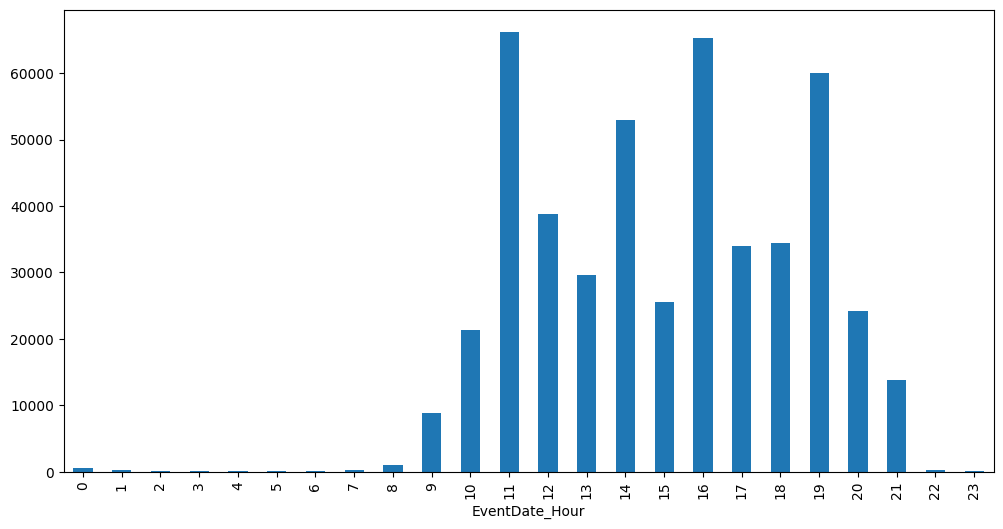

In [295]:
# look hout distribution
df_emails['EventDate_Hour'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))

## Releases

In [22]:
# look
print(df_releases.shape)
df_releases.head()

(412, 3)


,TX_PELICULA_UNICA,ESTRENO,VENTAS
0,48HFP X EDICIÓN: GRUPO A,2024-01-13,191
1,48HFP X EDICIÓN: GRUPO B,2024-01-13,189
2,57 SEGUNDOS ATRÁS,2024-02-19,97140
3,74MICT CIELO ROJO,2024-02-14,70
4,74MICT CLUB CERO,2024-02-09,46


In [23]:
# info
df_releases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TX_PELICULA_UNICA  412 non-null    object
 1   ESTRENO            412 non-null    object
 2   VENTAS             412 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 9.8+ KB


In [151]:
# ESTRENO as datetime
df_releases['ESTRENO'] = pd.to_datetime(df_releases['ESTRENO'], format='%Y-%m-%d', errors='coerce')

In [25]:
# describe
df_releases.describe(include='all')

,TX_PELICULA_UNICA,ESTRENO,VENTAS
count,412,412,4.120000e+02
unique,412,NaN,NaN
top,48HFP X EDICIÓN: GRUPO A,NaN,NaN
freq,1,NaN,NaN
mean,NaN,2024-04-14 20:33:47.184466176,9.456508e+04
min,NaN,2024-01-01 00:00:00,0.000000e+00
25%,NaN,2024-02-18 12:00:00,2.375000e+01
50%,NaN,2024-04-25 00:00:00,8.950000e+02
75%,NaN,2024-06-11 00:00:00,2.662950e+04
max,NaN,2024-08-21 00:00:00,6.156314e+06


In [26]:
# movies with 0 VENTAS
df_releases.query('VENTAS == 0').shape

(1, 3)

In [27]:
# remove
df_releases = df_releases.query('VENTAS > 0').reset_index(drop=True)

## Holidays

In [28]:
# get holidays for Mexico in the trx period
start_date = df_transactions['FECHA_TRANSACCION'].min()
end_date = df_transactions['FECHA_TRANSACCION'].max()
date_range = pd.date_range(start=start_date, end=end_date)
mx_holidays = holidays.MX(years=date_range.year.unique())

# create a DataFrame of holidays in the range
holiday_dates = [d for d in date_range if d in mx_holidays]
holiday_names = [mx_holidays[d] for d in holiday_dates]
df_mx_holidays = pd.DataFrame({'date': holiday_dates, 'holiday': holiday_names})

# upper window for holidays
df_mx_holidays['lower_window'] = 0
df_mx_holidays['upper_window'] = 0

# look
df_mx_holidays

,date,holiday,lower_window,upper_window
0,2024-01-01,Año Nuevo,0,0
1,2024-02-05,Día de la Constitución,0,0
2,2024-03-18,Natalicio de Benito Juárez,0,0
3,2024-05-01,Día del Trabajo,0,0


---
# EDA Sales

## S1: Observations

In [29]:
# how many sales they were
print(f"Total trx: {df_transactions.shape[0]}")
print(f"Total tickets: {df_transactions['BOLETOS'].sum()}")
print(f"Average tickets per trx: {df_transactions['BOLETOS'].mean():.2f}")
print(f"More than 1 ticket: {df_transactions['BOLETOS'].gt(1).mean():.4f}")
print(f"99 percentile: {df_transactions['BOLETOS'].quantile(0.99):.2f}")
print(f"More than 12 ticket: {df_transactions['BOLETOS'].gt(12).mean():.4f}") # the promotion
# get 99 percentile
print("Description of BOLETOS:\n")
print(df_transactions['BOLETOS'].describe())

Total trx: 321600
Total tickets: 667420
Average tickets per trx: 2.08
More than 1 ticket: 0.7474
99 percentile: 6.00
More than 12 ticket: 0.0003
Description of BOLETOS:

count    321600.000000
mean          2.075311
std           1.104101
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          65.000000
Name: BOLETOS, dtype: float64


## S2: Time Series

In [30]:
# time series of BOLETOS
ts_tickets = (
    df_transactions
    .groupby('FECHA_FUNCION', as_index=False)
    .agg({'BOLETOS': ['sum', 'count']})
    .rename(columns={'FECHA_FUNCION': 'date'})
    # reset index to flatten the DataFrame
    .reset_index(drop=True)
    # flatten the MultiIndex columns
    .set_axis(['date', 'total_tickets', 'total_transactions'], axis=1)
)

# reindex to get all dates in the range
date_range = pd.date_range(start=ts_tickets['date'].min(), end=ts_tickets['date'].max())
ts_tickets = ts_tickets.set_index('date').reindex(date_range).reset_index()
ts_tickets = ts_tickets.rename(columns={'index': 'date'})
ts_tickets['total_tickets'] = ts_tickets['total_tickets'].fillna(0)

# merge with holidays
ts_tickets = ts_tickets.merge(df_mx_holidays, how='left', on='date')

# look
print(ts_tickets.shape)
print("Date range as timedelta:", ts_tickets['date'].max() - ts_tickets['date'].min())
ts_tickets.head()

(237, 6)
Date range as timedelta: 236 days 00:00:00


,date,total_tickets,total_transactions,holiday,lower_window,upper_window
0,2024-01-01,4992.0,2273.0,Año Nuevo,0.0,0.0
1,2024-01-02,3996.0,1600.0,NaN,NaN,NaN
2,2024-01-03,2721.0,1154.0,NaN,NaN,NaN
3,2024-01-04,2063.0,929.0,NaN,NaN,NaN
4,2024-01-05,2029.0,921.0,NaN,NaN,NaN


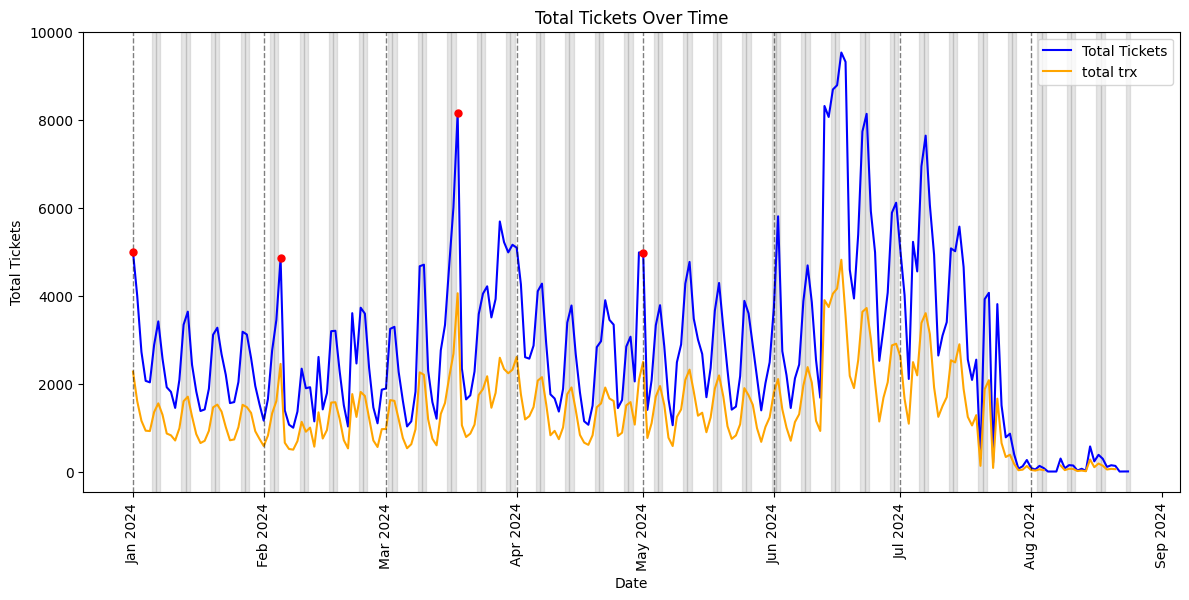

In [31]:
# plot total tickets over time
plt.figure(figsize=(12, 6))
plt.plot(ts_tickets['date'], ts_tickets['total_tickets'], label='Total Tickets', color='blue')
plt.plot(ts_tickets['date'], ts_tickets['total_transactions'], label='total trx', color='orange')

# addorn
plt.title('Total Tickets Over Time')
plt.xlabel('Date')
plt.ylabel('Total Tickets')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add dashed vertical lines for each month change
month_changes = ts_tickets['date'][ts_tickets['date'].dt.is_month_start]
for month_start in month_changes:
    ax.axvline(month_start, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Highlight weekends
for d in ts_tickets['date']:
    if d.weekday() >= 5:  # Saturday=5, Sunday=6
        ax.axvspan(d - pd.Timedelta(hours=12), d + pd.Timedelta(hours=12), color='gray', alpha=0.2)

# add red dot for each holiday
for _, row in df_mx_holidays.iterrows():
    if row['holiday'] and row['date'] in ts_tickets['date'].values:
        plt.plot(row['date'], ts_tickets.loc[ts_tickets['date'] == row['date'], 'total_tickets'].values[0], 'ro', markersize=5, label='Holiday')

plt.show()

Note:
- There is a shift of the weekend effect of 1 day in the data when a holiday is present

## S3: Decomposition

In [32]:
# decompose the daily sales using prophetand account for holidays
df_prophet = (
    ts_tickets
    .rename(columns={'date': 'ds', 'total_tickets': 'y'})
    .assign(
        ds=lambda x: pd.to_datetime(x['ds'], format='%Y-%m-%d', errors='coerce'),
        y=lambda x: x['y'].astype(float)
    )
    .dropna(subset=['ds', 'y'])
    .query("ds.le(@MAX_DATE)")
    .drop(columns=['total_transactions', 'holiday'])
)

# see
df_prophet

,ds,y,lower_window,upper_window
0,2024-01-01,4992.0,0.0,0.0
1,2024-01-02,3996.0,NaN,NaN
2,2024-01-03,2721.0,NaN,NaN
3,2024-01-04,2063.0,NaN,NaN
4,2024-01-05,2029.0,NaN,NaN
...,...,...,...,...
178,2024-06-27,3261.0,NaN,NaN
179,2024-06-28,4071.0,NaN,NaN
180,2024-06-29,5889.0,NaN,NaN
181,2024-06-30,6116.0,NaN,NaN


14:00:36 - cmdstanpy - INFO - Chain [1] start processing
14:00:36 - cmdstanpy - INFO - Chain [1] done processing
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1562: RuntimeWarning: 

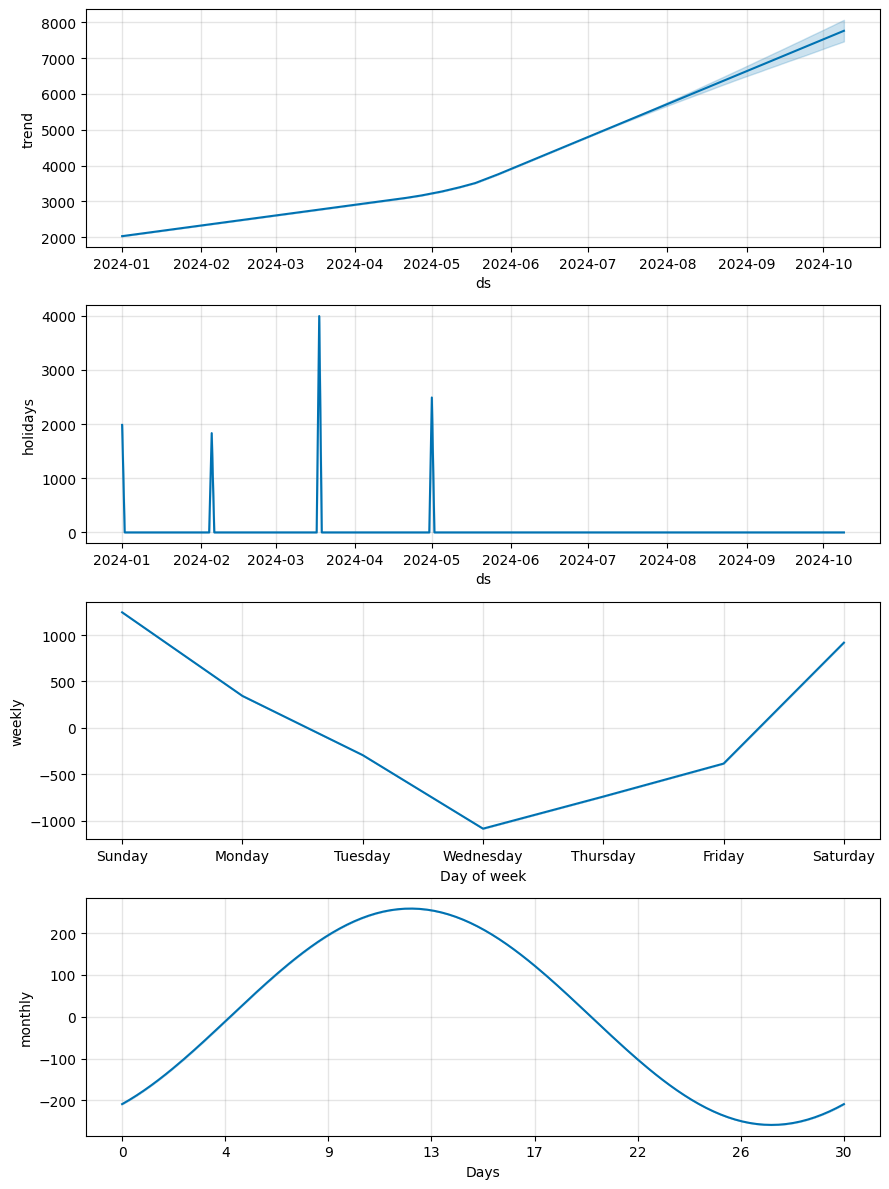

In [33]:
# create a Prophet model
model = Prophet(
    changepoint_prior_scale=0.05,  # Flexibility of the trend changes (default 0.05)
    changepoint_range=1,        # Proportion of the history in which trend changes are allowed
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False, # i dont have a complete year of data
    holidays=df_mx_holidays.rename(columns={'date': 'ds'}),
    seasonality_mode='additive',
)

# Add monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=1)

# Fit using 4 chains
model.fit(df_prophet)

# future
future = model.make_future_dataframe(periods=100, freq='D')

# predict
forecast = model.predict(future)
fig = model.plot_components(forecast)

---
# Emails

## S1: Obervations

### emails sent

In [112]:
# unique event dates
print("Unique event dates in emails:", df_emails['EventDate'].nunique())

print("Unique campaigns in emails:", df_emails['SendId'].nunique())
print("Campaigns with more than 100 email: ", df_emails['SendId'].value_counts().ge(100).sum())

print("number of distinct clients:", df_emails['CARD_MEMBERSHIPID'].nunique())
print("Avg emails per client:", df_emails['CARD_MEMBERSHIPID'].value_counts().mean()) # good, 

Unique event dates in emails: 256
Unique campaigns in emails: 941
Campaigns with more than 100 email:  526
number of distinct clients: 454740
Avg emails per client: 1.052232044684875


In [113]:
# merge with trx
df_trx_and_emailed = (
    df_transactions
    .groupby('CARD_MEMBERSHIPID', as_index=False)
    .agg(
        total_tickets=('BOLETOS', 'sum'),
        total_transactions=('transaction_id', 'nunique'),
        total_spent=('IMPORTE_TAQUILLA', 'sum')
    )
    .merge(
        df_emails.groupby('CARD_MEMBERSHIPID', as_index=False).agg(num_emails=('SendId', 'nunique')),
        how='left',
        on='CARD_MEMBERSHIPID'
    )
    .assign(
        num_emails=lambda x: x['num_emails'].fillna(0).astype(int)
    )
)

# look
print(f"Users with emails: {df_trx_and_emailed['num_emails'].gt(0).mean()}")
print(f"Users with emails: {df_trx_and_emailed['num_emails'].gt(0).sum()}")
print(f"Unique users: {df_trx_and_emailed['CARD_MEMBERSHIPID'].nunique()}")
df_trx_and_emailed


Users with emails: 0.0832768639624463
Users with emails: 21998
Unique users: 264155


,CARD_MEMBERSHIPID,total_tickets,total_transactions,total_spent,num_emails
0,000106af97d98ed498a1e0a57abe8ef355e398a53a1cd9...,2,1,85.0,0
1,0001d0121dbac20ce03daf9e602e3d30c2b8f6af91af0b...,4,2,234.0,0
2,0001d5513d3c4ad1c33d3091dc22fbc5c7094fbf9066ed...,1,1,80.0,0
3,0002a429f0ac9ceb47bcc659efb13985fa4467f2c4e231...,2,1,92.0,0
4,0003314dbc6a79aca19aef736204b58626af7fbeaf0748...,2,1,158.0,1
...,...,...,...,...,...
264150,ffff152876de205f010d43873ec99ebf10140ce27c016e...,1,1,54.0,1
264151,ffff410ea0698ec69646c1aafa2a77701f689f0353decb...,1,1,100.0,0
264152,ffff5fda5a1e2b34873d8d60fc0931e93d199dae49c359...,2,1,144.0,0
264153,ffffac998df9587da49f9973a8b497fca19da2589d6b09...,4,2,188.0,1


In [126]:
# see clients with more 1 email
print(f"Amount of emails: {df_trx_and_emailed['num_emails'].sum()}")
df_trx_and_emailed.query('num_emails.ge(1)').sort_values(by='num_emails', ascending=False)

Amount of emails: 23223


,CARD_MEMBERSHIPID,total_tickets,total_transactions,total_spent,num_emails
189114,b763d652794f32a344e07ac4e512ac2be6459fd1856510...,2,1,55.0,3
223526,d8df0658c0963ca08919c4788df1f2de469f1b1fae846b...,1,1,99.0,3
211798,cd65ccbb5dfc5899a78e97e9a14740bd2b63e9eb6c4b66...,2,1,144.0,3
128046,7c1d1e5324826d9ce5fd42d978d68555660559b03dc4bc...,6,3,259.0,3
35128,22062e6a64cd62becd0438f8afa9787638c36bbe7d071f...,2,1,82.0,3
...,...,...,...,...,...
88152,554d25dd3ba1a5f24af3a86e25e693245f741dea6e1f5d...,2,1,0.0,1
88150,554cce3f8f3f274f76e3286cd06dd72809d747ae3b14a0...,1,1,0.0,1
88123,554700931a2d98f21749f62d04524f012bddc8e107c499...,5,1,320.0,1
88119,5545fc09cb7c0bc3634b66f5ef0c44a53249d463093958...,1,1,90.0,1


In [218]:
# time series of emails sent
ts_emails = (
    df_emails
    .groupby('EventDate', as_index=False)
    .size()
    .rename(columns={'EventDate': 'date', 'size': 'emails_sent'})
    .sort_values(by='date', ascending=True, ignore_index=True)
    # emails sent after 2024
    .loc[lambda x: x['date'].ge(dt.date(2024, 1, 1))]
    # astype
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%Y-%m-%d', errors='coerce'))

)


# look
print(ts_emails.shape)
print("amount of emails sent:", ts_emails['emails_sent'].sum())
ts_emails.head()

(184, 2)
amount of emails sent: 355438


,date,emails_sent
72,2024-01-01,387
73,2024-01-02,201
74,2024-01-03,2431
75,2024-01-04,4498
76,2024-01-06,583


<StemContainer object of 3 artists>

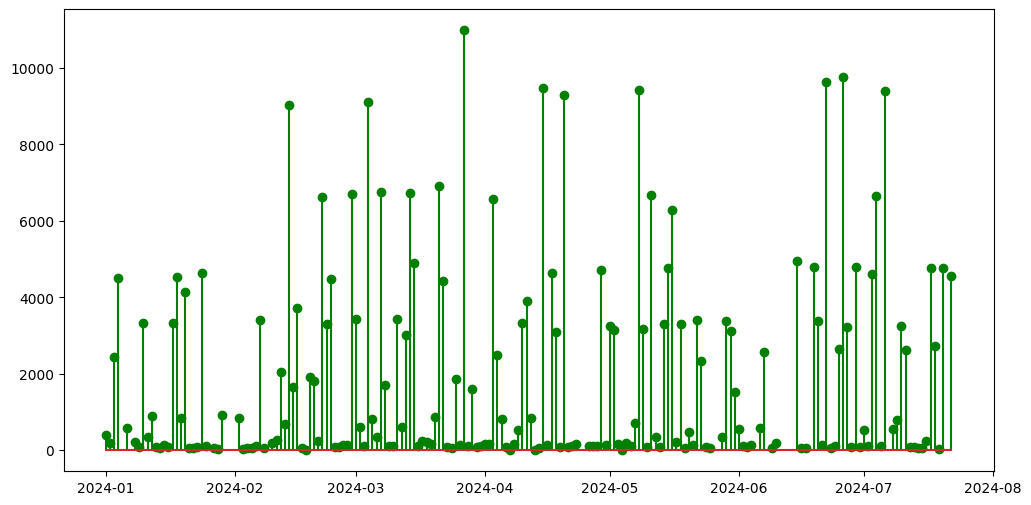

In [221]:
# plot ts of emails sent as lollipop chart
plt.figure(figsize=(12, 6))
plt.stem(ts_emails['date'], ts_emails['emails_sent'], label='Emails Sent', linefmt='green', markerfmt='go')

<StemContainer object of 3 artists>

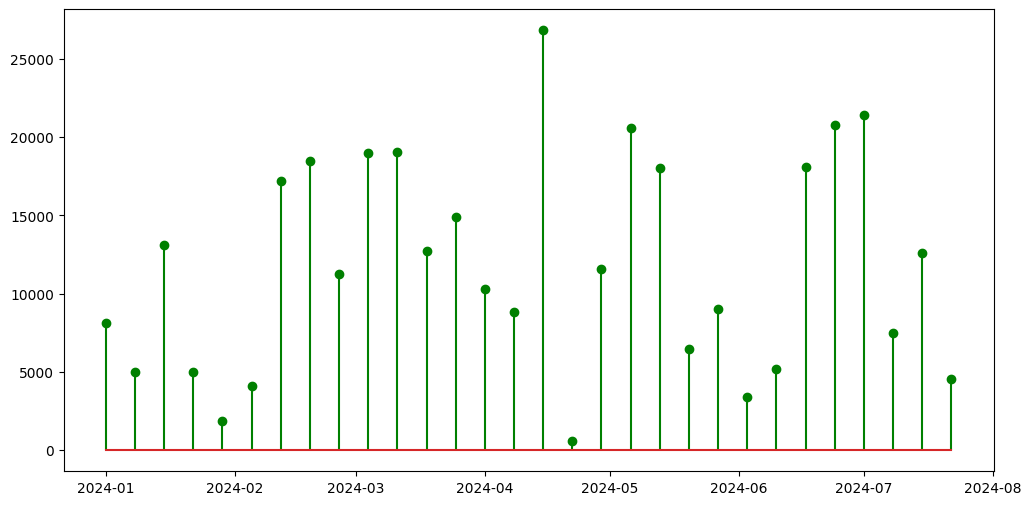

In [223]:
# for each date of email sent get the year week and plot it
ts_emails['year_week'] = ts_emails['date'].dt.to_period('W').dt.start_time
ts_emails_weekly = (
    ts_emails
    .groupby('year_week', as_index=False)
    .agg({'emails_sent': 'sum'})
    .rename(columns={'year_week': 'date'})
)

plt.figure(figsize=(12, 6))
plt.stem(ts_emails_weekly['date'], ts_emails_weekly['emails_sent'], label='Emails Sent', linefmt='green', markerfmt='go')

### campaigns

In [54]:
# table of SendId and number of emails
(
    df_emails
    .groupby(['SendId', 'EventDate'])
    .size()
    .unstack().fillna(0).astype(int)
)

EventDate,2023-10-10,2023-10-11,2023-10-12,2023-10-13,2023-10-14,2023-10-15,2023-10-16,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-21,2023-10-22,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-28,2023-10-29,2023-10-30,2023-10-31,2023-11-03,2023-11-04,2023-11-05,2023-11-06,2023-11-07,2023-11-08,2023-11-09,2023-11-10,2023-11-11,2023-11-12,2023-11-13,2023-11-15,2023-11-16,2023-11-17,2023-11-18,2023-11-19,2023-11-20,2023-11-21,2023-11-22,2023-11-25,2023-11-26,2023-11-27,2023-11-28,2023-11-29,2023-11-30,2023-12-01,2023-12-02,2023-12-03,2023-12-04,2023-12-06,2023-12-07,2023-12-08,2023-12-10,2023-12-11,2023-12-12,2023-12-13,2023-12-15,2023-12-16,2023-12-17,2023-12-18,2023-12-19,2023-12-20,2023-12-21,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-28,2023-12-29,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-06,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-13,2024-01-14,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-20,2024-01-21,2024-01-22,2024-01-23,2024-01-24,2024-01-25,2024-01-27,2024-01-28,2024-01-29,2024-02-02,2024-02-03,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-10,2024-02-11,2024-02-12,2024-02-13,2024-02-14,2024-02-15,2024-02-16,2024-02-17,2024-02-18,2024-02-19,2024-02-20,2024-02-21,2024-02-22,2024-02-23,2024-02-24,2024-02-25,2024-02-26,2024-02-27,2024-02-28,2024-02-29,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-23,2024-03-24,2024-03-25,2024-03-26,2024-03-27,2024-03-28,2024-03-29,2024-03-30,2024-03-31,2024-04-01,2024-04-02,2024-04-03,2024-04-04,2024-04-05,2024-04-06,2024-04-07,2024-04-08,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-13,2024-04-14,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-20,2024-04-21,2024-04-22,2024-04-23,2024-04-26,2024-04-27,2024-04-28,2024-04-29,2024-04-30,2024-05-01,2024-05-02,2024-05-03,2024-05-04,2024-05-05,2024-05-06,2024-05-07,2024-05-08,2024-05-09,2024-05-10,2024-05-11,2024-05-12,2024-05-13,2024-05-14,2024-05-15,2024-05-16,2024-05-17,2024-05-18,2024-05-19,2024-05-20,2024-05-21,2024-05-22,2024-05-23,2024-05-24,2024-05-25,2024-05-28,2024-05-29,2024-05-30,2024-05-31,2024-06-01,2024-06-02,2024-06-03,2024-06-04,2024-06-06,2024-06-07,2024-06-09,2024-06-10,2024-06-15,2024-06-16,2024-06-17,2024-06-19,2024-06-20,2024-06-21,2024-06-22,2024-06-23,2024-06-24,2024-06-25,2024-06-26,2024-06-27,2024-06-28,2024-06-29,2024-06-30,2024-07-01,2024-07-02,2024-07-03,2024-07-04,2024-07-05,2024-07-06,2024-07-08,2024-07-09,2024-07-10,2024-07-11,2024-07-12,2024-07-13,2024-07-14,2024-07-15,2024-07-16,2024-07-17,2024-07-18,2024-07-19,2024-07-20,2024-07-22
SendId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1360577,29,32,31,29,22,25,24,38,44,28,27,13,11,18,33,27,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1360578,14,15,14,9,2,14,12,13,13,10,8,9,9,4,23,21,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [101]:
# get amount of emails per campaign
df_emails_per_campaign = (
    df_emails
    .groupby('SendId', as_index=False)
    .agg(
        EventDate=('EventDate', 'count'),
        num_days=('EventDate', lambda x: (x.max() - x.min()).days),
        date_start=('EventDate', 'min'),
        date_end=('EventDate', 'max')
    )
    .rename(columns={'EventDate': 'num_emails'})
)

# look
print(df_emails_per_campaign.shape)
print("Campaigns with more than 1000 emails:", df_emails_per_campaign['num_emails'].ge(1000).sum())
df_emails_per_campaign.sort_values(by='num_emails')

(941, 5)
Campaigns with more than 1000 emails: 125


,SendId,num_emails,num_days,date_start,date_end
362,1449357,1,0,2024-01-17,2024-01-17
450,1451697,1,0,2024-02-16,2024-02-16
449,1451695,1,0,2024-02-22,2024-02-22
447,1451692,1,0,2024-02-21,2024-02-21
446,1451691,1,0,2024-02-21,2024-02-21
...,...,...,...,...,...
782,1455384,6474,0,2024-05-08,2024-05-08
563,1452762,8966,0,2024-03-04,2024-03-04
728,1454551,9166,0,2024-04-15,2024-04-15
898,1457396,9335,0,2024-07-06,2024-07-06


In [102]:
# order by num_days
df_emails_per_campaign.sort_values(by='num_days', ascending=False).head(10)

,SendId,num_emails,num_days,date_start,date_end
92,1444964,4416,225,2023-10-28,2024-06-09
91,1444963,2139,225,2023-10-28,2024-06-09
89,1444961,1708,224,2023-10-29,2024-06-09
155,1446455,3432,197,2023-11-25,2024-06-09
90,1444962,1184,116,2023-10-28,2024-02-21
494,1452018,1546,108,2024-02-22,2024-06-09
685,1454266,21,86,2024-04-03,2024-06-28
689,1454270,1506,83,2024-04-05,2024-06-27
698,1454280,1632,83,2024-04-05,2024-06-27
691,1454272,1021,83,2024-04-05,2024-06-27


In [118]:
# percent of campaigns that num_days is eq 0
print(f"Emails within the same day: {df_emails_per_campaign.query('num_days.le(0)')['num_emails'].sum() / df_emails_per_campaign['num_emails'].sum() * 100:.2f}%")
print(f"Campaigns within the same day: {df_emails_per_campaign.query('num_days.le(0)').shape[0] / df_emails_per_campaign.shape[0] * 100:.2f}%")

Emails within the same day: 85.39%
Campaigns within the same day: 83.63%


In [120]:
# look each date and the number of campaigns
ts_campaigns_by_date = (
    df_emails
    .groupby('EventDate')['SendId']
    .nunique()
    .reset_index(name='num_campaigns')
)

# see
print(ts_campaigns_by_date.shape)
print("Only 1 campaign per date:", ts_campaigns_by_date['num_campaigns'].eq(1).sum())
print("Avg number of campaigns per date:", ts_campaigns_by_date['num_campaigns'].mean())
ts_campaigns_by_date.head()

(256, 2)
Only 1 campaign per date: 9
Avg number of campaigns per date: 9.671875


,EventDate,num_campaigns
0,2023-10-10,5
1,2023-10-11,11
2,2023-10-12,11
3,2023-10-13,13
4,2023-10-14,11


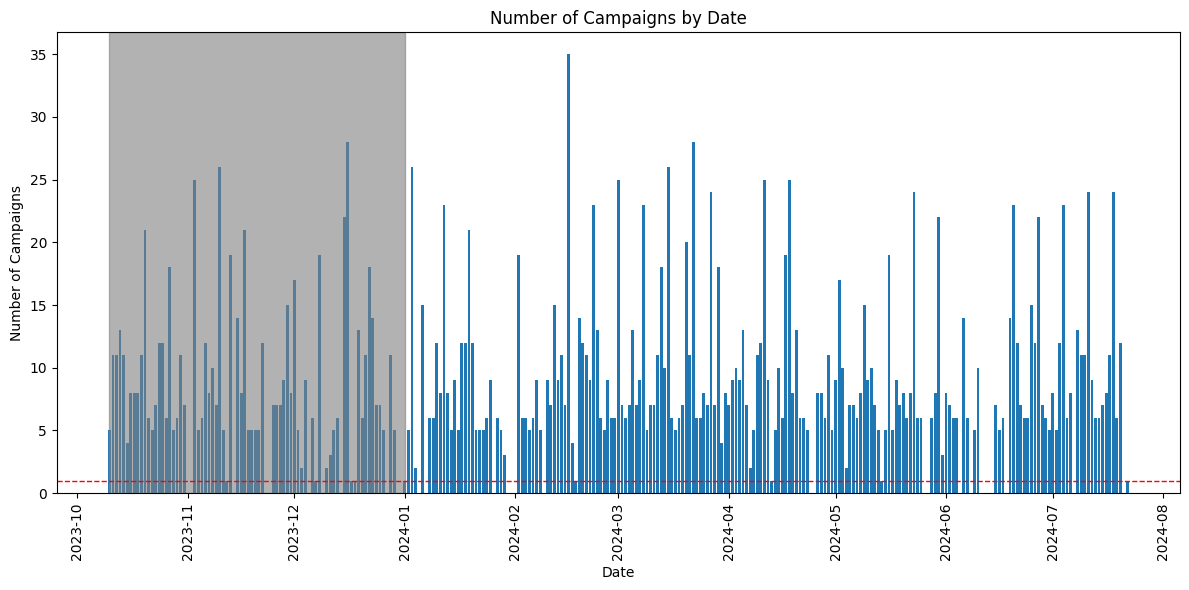

In [121]:
# plot ts campaigns by like lollipop
plt.figure(figsize=(12, 6))
plt.bar(ts_campaigns_by_date['EventDate'], ts_campaigns_by_date['num_campaigns'], width=0.8)

# add hline at 1
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='1 Campaign')

# add gray background for data before 2024-01-01
plt.axvspan(ts_campaigns_by_date['EventDate'].min(), dt.datetime(2024, 1, 1), color='gray', alpha=0.6, label='Before 2024')

# addorn
plt.title('Number of Campaigns by Date')
plt.xlabel('Date')
plt.ylabel('Number of Campaigns')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [122]:
# top 10 campaigns by number of emails
df_emails_per_campaign.sort_values(by='num_emails', ascending=False).head(10)

,SendId,num_emails,num_days,date_start,date_end
847,1456992,9513,0,2024-06-22,2024-06-22
898,1457396,9335,0,2024-07-06,2024-07-06
728,1454551,9166,0,2024-04-15,2024-04-15
563,1452762,8966,0,2024-03-04,2024-03-04
535,1452504,6474,0,2024-02-29,2024-02-29
782,1455384,6474,0,2024-05-08,2024-05-08
861,1457059,5393,0,2024-06-26,2024-06-26
624,1453554,5353,0,2024-03-21,2024-03-21
761,1454869,5263,0,2024-04-20,2024-04-20
573,1452933,5260,0,2024-03-07,2024-03-07


## S2: Convertion Rates

In [264]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478492 entries, 0 to 478491
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventDate          478492 non-null  datetime64[ns]
 1   SendId             478492 non-null  int64         
 2   CARD_MEMBERSHIPID  478492 non-null  object        
 3   EventDate_TZ       478492 non-null  datetime64[ns]
 4   EventDate_Hour     478492 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(1)
memory usage: 16.4+ MB


In [272]:
# merge between emails unique card_membershipid and transactions unique card_membershipid
df_users_emails_unique = df_emails[['CARD_MEMBERSHIPID']].drop_duplicates().reset_index(drop=True)
df_users_trx_unique = df_transactions[['CARD_MEMBERSHIPID']].drop_duplicates().reset_index(drop=True)
df_users_join = (
    df_users_emails_unique
    .merge(df_users_trx_unique, how='inner', on='CARD_MEMBERSHIPID')
    .reset_index(drop=True)
)

print(f"Total users with emails: {df_users_emails_unique.shape[0]}")
print(f"Total users with transactions: {df_users_trx_unique.shape[0]}")
print(f"Total users with both emails and transactions: {df_users_join.shape[0]}")

Total users with emails: 454740
Total users with transactions: 264155
Total users with both emails and transactions: 21998


In [296]:
# join for each email the CARD_MEMBERSHIPID and EventDate
df_emails_convertion = (
    df_emails
    .merge(
        df_transactions[['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION', 'BOLETOS']],
        how='inner',
        left_on=['CARD_MEMBERSHIPID', 'EventDate'],
        right_on=['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION']
    )
)

# look
print(df_emails_convertion.shape)
df_emails_convertion.head()

(91, 7)


,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour,FECHA_TRANSACCION,BOLETOS
0,2024-06-20,1456917,171f37dadf10e74321afed2b22fa59ac5427c2dc77db62...,2024-06-20 15:18:31,15,2024-06-20,2
1,2024-05-08,1455384,0d20bbdfb28564b9ce0367d898d594005bffb0b3a31fda...,2024-05-08 16:16:01,16,2024-05-08,2
2,2024-03-14,1453269,40a5a88bbe8dafb496df644a4eb36b4c383ad96425faba...,2024-03-14 17:22:29,17,2024-03-14,2
3,2024-07-17,1457634,0c2c955f2e65d68e2c2877f9f566f14459602b89aeebc6...,2024-07-17 16:24:01,16,2024-07-17,1
4,2024-07-09,1457452,66289323e079e3e77c846d8da63b52103acfef448aba5d...,2024-07-09 19:39:37,19,2024-07-09,1


For the same day only 91 of 454740 emails had a transaction, which is 0.02% of the emails sent.
And from 21998 users with emails and transactions, only 91 had a transaction on the same day as the email, which is 0.41% 

---
# Movies

## S1: Observed

In [ ]:
# time series of movies by date
ts_movies_by_date = (
    df_releases
    .groupby('ESTRENO')
    .size()
    .reset_index(name='num_movies')
)

# reindex to get all dates in the range
date_range = pd.date_range(start=df_transactions['FECHA_FUNCION'].min(), end=df_transactions['FECHA_FUNCION'].max())
ts_movies_by_date = ts_movies_by_date.set_index('ESTRENO').reindex(date_range).reset_index()
ts_movies_by_date = ts_movies_by_date.rename(columns={'index': 'ESTRENO'})
ts_movies_by_date['num_movies'] = ts_movies_by_date['num_movies'].fillna(0).astype(int)


# look
print(ts_movies_by_date.shape)
print("Movies released:", ts_movies_by_date['num_movies'].sum())
print("Unique release dates:", ts_movies_by_date['num_movies'].gt(0).sum())
ts_movies_by_date.head()

(237, 2)
Movies released: 411
Unique release dates: 94


,ESTRENO,num_movies
0,2024-01-01,32
1,2024-01-02,0
2,2024-01-03,0
3,2024-01-04,8
4,2024-01-05,0


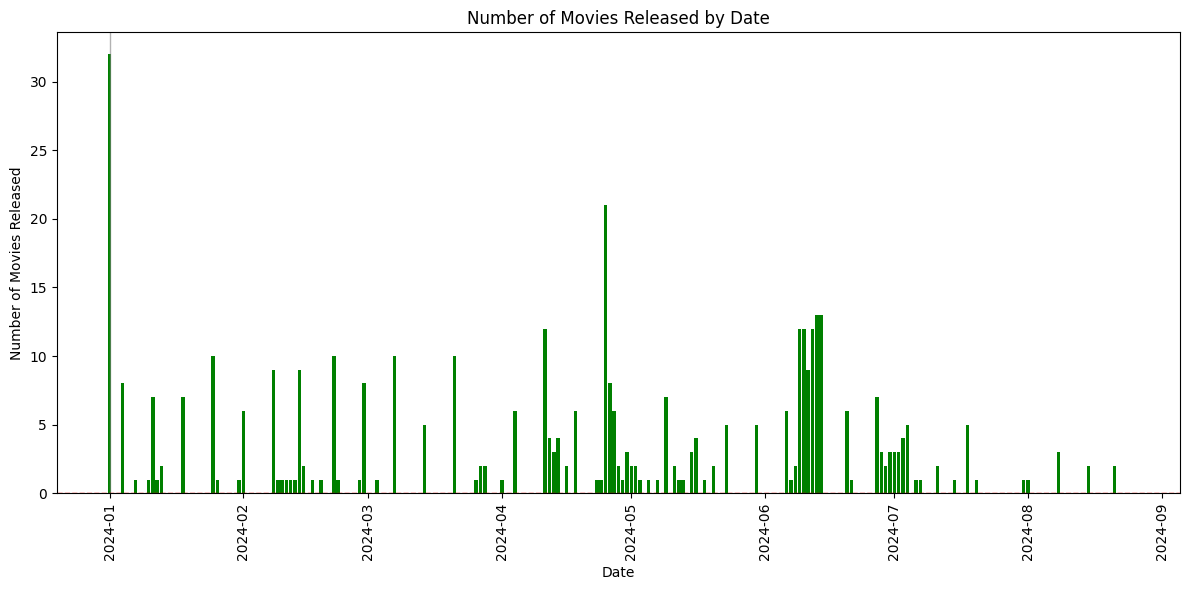

In [ ]:
# plot time series of movies by date as lollipop
plt.figure(figsize=(12, 6))
plt.bar(ts_movies_by_date['ESTRENO'], ts_movies_by_date['num_movies'], width=0.8, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='No Movies')
plt.axvspan(ts_movies_by_date['ESTRENO'].min(), dt.datetime(2024, 1, 1), color='gray', alpha=0.6, label='Before 2024')
plt.title('Number of Movies Released by Date')
plt.xlabel('Date')
plt.ylabel('Number of Movies Released')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## S2: Gap/Gantt Analysis

In [ ]:
# for each movie get range of dates
df_releases_range = (
    df_transactions
    .groupby('TX_PELICULA_UNICA', as_index=False)
    .agg(
        date_end=('FECHA_FUNCION', 'max'),
        tickets_sold=('BOLETOS', 'sum'),
        money_sold=('IMPORTE_TAQUILLA', 'sum'),
    )
    .merge(
        df_releases,
        how='inner',
        on='TX_PELICULA_UNICA'
    )
    .assign(
        days_on_air=lambda x: (x['date_end'] - x['ESTRENO']).dt.days,
        blockbuster_score=lambda x: np.log2(x['VENTAS']),
        date_before_release=lambda x: x['ESTRENO'] - pd.Timedelta(days=2),
    )
)

# look
print(df_releases_range.shape)
df_releases_range.sort_values(by='days_on_air', ascending=False)

(246, 9)


,TX_PELICULA_UNICA,date_end,tickets_sold,money_sold,ESTRENO,VENTAS,days_on_air,blockbuster_score,date_before_release
104,GODZILA VS KONG,2024-04-22,16,710.0,2024-01-04,194,109,7.599913,2024-01-02
75,EL NIÑO Y LA GARZA,2024-04-02,3510,308836.0,2024-01-01,226635,92,17.790011,2023-12-30
151,MI AMIGO ROBOT,2024-06-01,5300,308408.5,2024-03-07,375007,86,18.516558,2024-03-05
137,LAZOS DE VIDA,2024-06-04,3140,261828.5,2024-03-14,195574,82,17.577355,2024-03-12
129,KUNG FU PANDA 4,2024-05-22,43851,2707940.0,2024-03-03,2423042,80,21.208388,2024-03-01
...,...,...,...,...,...,...,...,...,...
1,74MICT CIELO ROJO,2024-02-14,6,198.0,2024-02-14,70,0,6.129283,2024-02-12
45,CONSPIRACIÓN DIVINA,2024-01-01,2,190.0,2024-01-01,351,0,8.455327,2023-12-30
198,SFF SESIÓN Q&A YOUR MONSTER,2024-04-26,4,1000.0,2024-04-26,206,0,7.686501,2024-04-24
197,SFF SESIÓN Q&A GOING VARSITY IN MARIACHI,2024-04-28,1,0.0,2024-04-28,30,0,4.906891,2024-04-26


Notes:
- From 411 movies only 246 had sales

In [ ]:
# build a ts of movies that counts how many movies are "on air" (that time is between date_before_release and date_end)
date_range = pd.date_range(start=df_releases_range['date_before_release'].min(), end=df_releases_range['date_end'].max())
ts_movies_on_air = (
    pd.DataFrame({'date': date_range})
    .assign(
        on_air=lambda x: x['date'].apply(
            lambda d: df_releases_range.query('date_before_release.le(@d) and date_end.ge(@d)').shape[0]
        ),
        blockbuster_score=lambda x: x['date'].apply(
            lambda d: df_releases_range.query('date_before_release.le(@d) and date_end.ge(@d)')['blockbuster_score'].sum()
        )
    )
)

# look
print(ts_movies_on_air.shape)
ts_movies_on_air

(239, 3)


,date,on_air,blockbuster_score
0,2023-12-30,26,330.612049
1,2023-12-31,26,330.612049
2,2024-01-01,26,330.612049
3,2024-01-02,29,383.376326
4,2024-01-03,26,360.557990
...,...,...,...
234,2024-08-20,2,27.800737
235,2024-08-21,2,27.800737
236,2024-08-22,1,10.856426
237,2024-08-23,1,10.856426


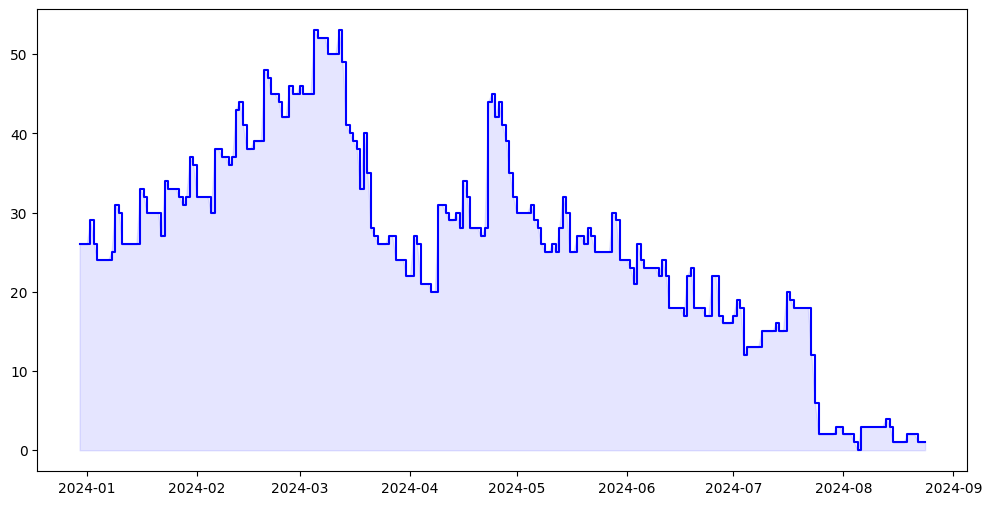

In [ ]:
# plot ts of movies on air as step line
plt.figure(figsize=(12, 6))
plt.step(ts_movies_on_air['date'], ts_movies_on_air['on_air'], where='post', label='Movies On Air', color='blue')
plt.fill_between(ts_movies_on_air['date'], ts_movies_on_air['on_air'], color='blue', alpha=0.1)

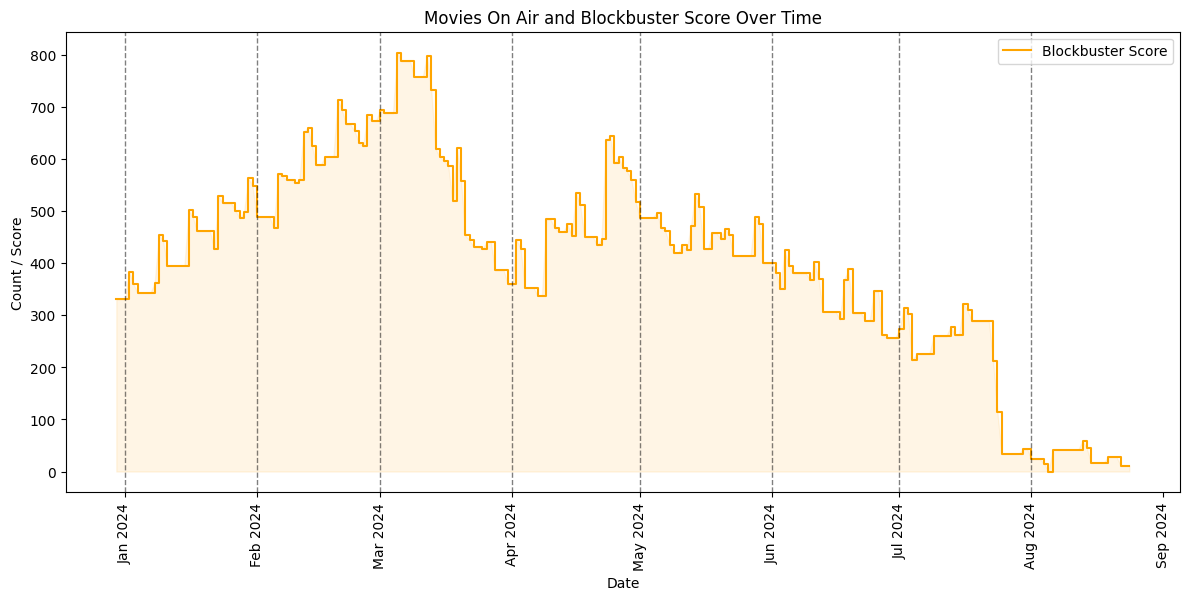

In [ ]:
# plot blockbuster score as step line
plt.figure(figsize=(12, 6))
plt.step(ts_movies_on_air['date'], ts_movies_on_air['blockbuster_score'], where='post', label='Blockbuster Score', color='orange')
plt.fill_between(ts_movies_on_air['date'], ts_movies_on_air['blockbuster_score'], color='orange', alpha=0.1)
plt.title('Movies On Air and Blockbuster Score Over Time')
plt.xlabel('Date')
plt.ylabel('Count / Score')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# Add dashed vertical lines for each month change
month_changes = ts_movies_on_air['date'][ts_movies_on_air['date'].dt.is_month_start]
for month_start in month_changes:
    ax.axvline(month_start, color='black', linestyle='--', linewidth=1, alpha=0.5)

# plot
plt.show()

In [ ]:
# for each day get the blockbuster score
ts_blockbuster_score = (
    df_releases_range
    # get year-week of date_before_release
    .assign(date_before_release=lambda x: x['date_before_release'].dt.to_period('W').dt.start_time)
    # group by date_before_release and sum blockbuster_score
    .groupby('date_before_release', as_index=False)
    .agg({'blockbuster_score': 'sum'})
)

# look
print(ts_blockbuster_score.shape)
ts_blockbuster_score.sort_values(by='blockbuster_score')

(34, 2)


,date_before_release,blockbuster_score
30,2024-07-29,8.936638
33,2024-08-19,10.856426
32,2024-08-12,16.944312
18,2024-04-29,41.440619
31,2024-08-05,41.882516
13,2024-03-25,44.276754
24,2024-06-10,51.288378
28,2024-07-08,52.764040
26,2024-06-24,56.358976
11,2024-03-11,59.262961


<BarContainer object of 34 artists>

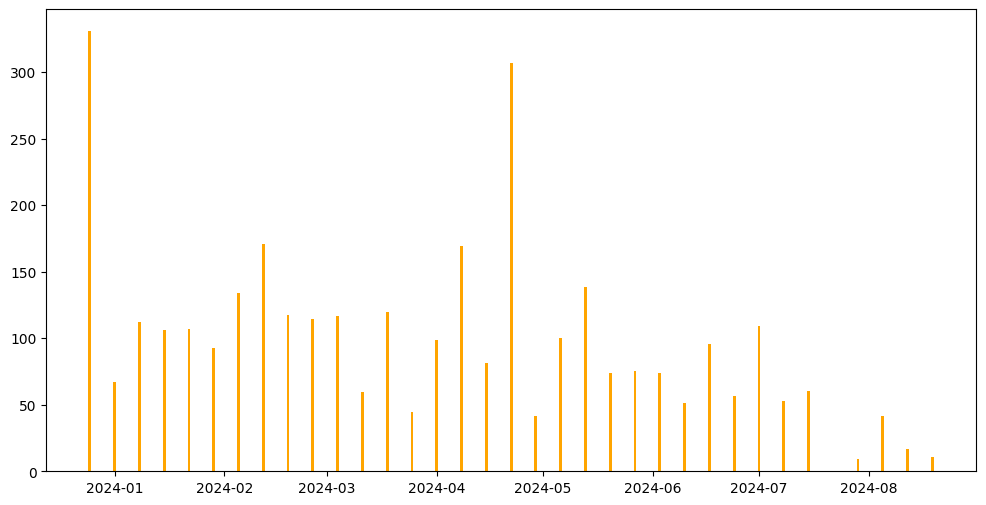

In [ ]:
# plot score per week as bar plot
plt.figure(figsize=(12, 6))
plt.bar(ts_blockbuster_score['date_before_release'], ts_blockbuster_score['blockbuster_score'], color='orange')

---
# Tickets

## S1: Kids

In [ ]:
# append pricebook to trx
df_transactions = df_transactions.merge(df_pricebook, how='left', on='ID_CINE')

In [ ]:
# get if the trx contained children tickets
df_transactions = (
    df_transactions
    .assign(
        had_children=lambda x: np.where(
            (x['IMPORTE_TAQUILLA'] / x['BOLETOS']).lt(x['PRECIO_POL_R']),
            1,
            0
        )
    )
)

# look
print(f"Total trx with kids: {df_transactions['had_children'].sum()}")
print(f"Percentage of trx with kids: {df_transactions['had_children'].mean() * 100:.2f}%")
df_transactions.head()

Total trx with kids: 220019
Percentage of trx with kids: 68.41%


,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,had_children
0,2ed9514e-4598-5a3a-b7eb-d3b71a312a07,903,2024-01-01,2024-01-01,246dcfe746f73242e3dc0ee6e1dff6ff169aae464c7af6...,7,AQUAMAN Y EL REINO PERDIDO,10,600.0,53.0,0
1,d8d32bdc-16d9-564c-a8ee-87125e669e33,355,2024-01-01,2024-01-01,d6de2ddad687c1471b307825bbaf6a5b54ca4ff8dfaab8...,1,EL NIÑO Y LA GARZA,5,450.0,77.0,0
2,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0,83.0,1
3,668f2c6a-af11-5552-a7e7-67d33ea470d3,273,2024-01-01,2024-01-01,f180d6ee7ed2986afc41d421ed36e84ca38fd437fb3a22...,1,¡PATOS!,2,82.0,75.0,1
4,b55a6b51-30ad-51dd-9317-58a2bcc5e9e4,905,2024-01-01,2024-01-01,b21d81b41698f87bf8a79ebe3bf52481f728d6b2542541...,5,PRISCILLA,2,370.0,166.0,0


## S2: Cinema Stats

In [ ]:
# for each cinema, get total count and total spent
df_cinema_stats = (
    df_transactions
    .groupby('ID_CINE', as_index=False)
    .agg(
        total_tickets=('BOLETOS', 'sum'),
        total_transactions=('transaction_id', 'nunique'),
        total_spent=('IMPORTE_TAQUILLA', 'sum'),
        had_children=('had_children', 'sum')
    )
    .sort_values(by='total_tickets', ascending=False, ignore_index=True)
    .assign(
        pct_children=lambda x: x['had_children'] / x['total_transactions']
    )
)

# look
print(df_cinema_stats.shape)
df_cinema_stats

(103, 6)


,ID_CINE,total_tickets,total_transactions,total_spent,had_children,pct_children
0,60,20591,10189,1312953.0,7623,0.748160
1,344,19423,9553,1296460.3,5942,0.622004
2,166,17824,9061,1089548.7,7061,0.779274
3,234,17065,8729,1050401.7,6434,0.737083
4,154,17045,8319,988814.0,6432,0.773170
...,...,...,...,...,...,...
98,1143,1459,700,65178.5,407,0.581429
99,452,1397,739,53951.5,470,0.635995
100,674,1043,495,39772.0,280,0.565657
101,11,875,404,32470.0,239,0.591584


Text(0, 0.5, 'Frequency')

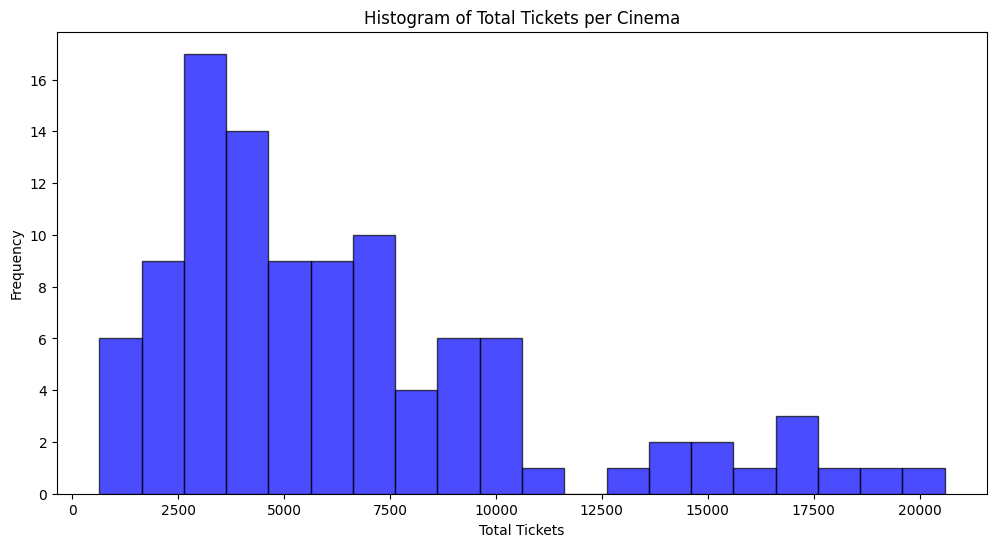

In [ ]:
# look histogram of total tickets per cinema
plt.figure(figsize=(12, 6))
plt.hist(df_cinema_stats['total_tickets'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Total Tickets per Cinema')
plt.xlabel('Total Tickets')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

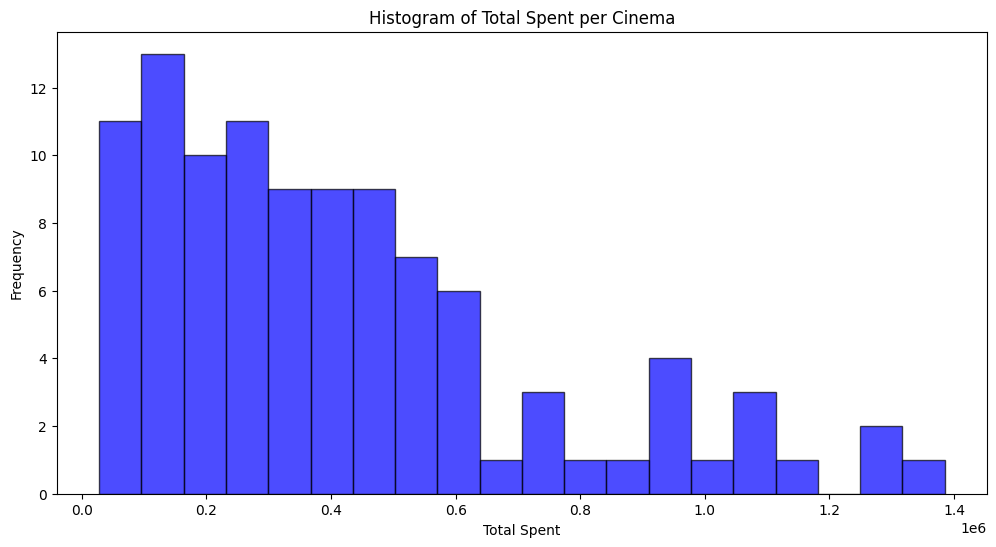

In [ ]:
# look histogram of total_spent per cinema
plt.figure(figsize=(12, 6))
plt.hist(df_cinema_stats['total_spent'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Total Spent per Cinema')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

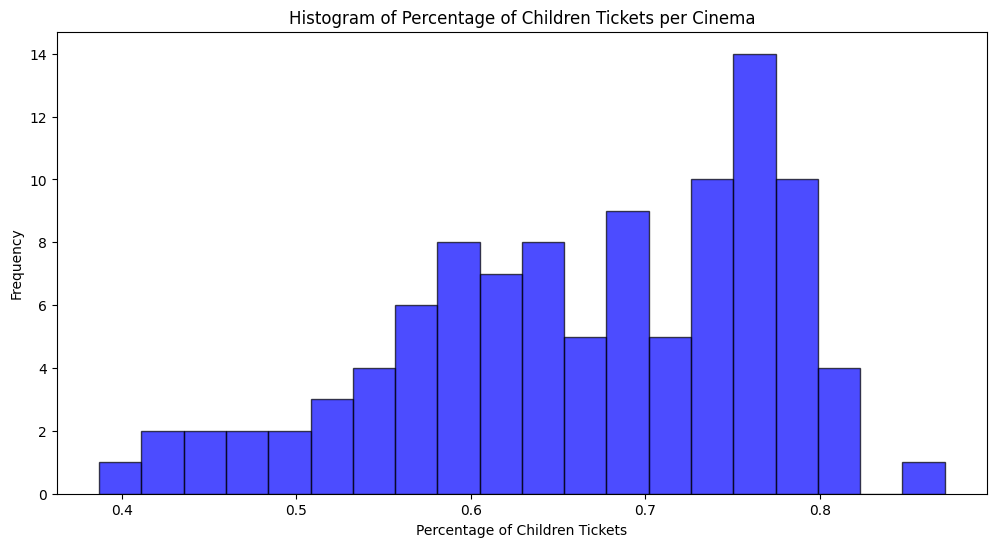

In [ ]:
# pct children per cinema histogram
plt.figure(figsize=(12, 6))
plt.hist(df_cinema_stats['pct_children'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Percentage of Children Tickets per Cinema')
plt.xlabel('Percentage of Children Tickets')
plt.ylabel('Frequency')

## S3: Timing

Description of time_diff:
count    321600.000000
mean          0.656651
std           3.622337
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          61.000000
Name: time_diff, dtype: float64


Text(0, 0.5, 'Density')

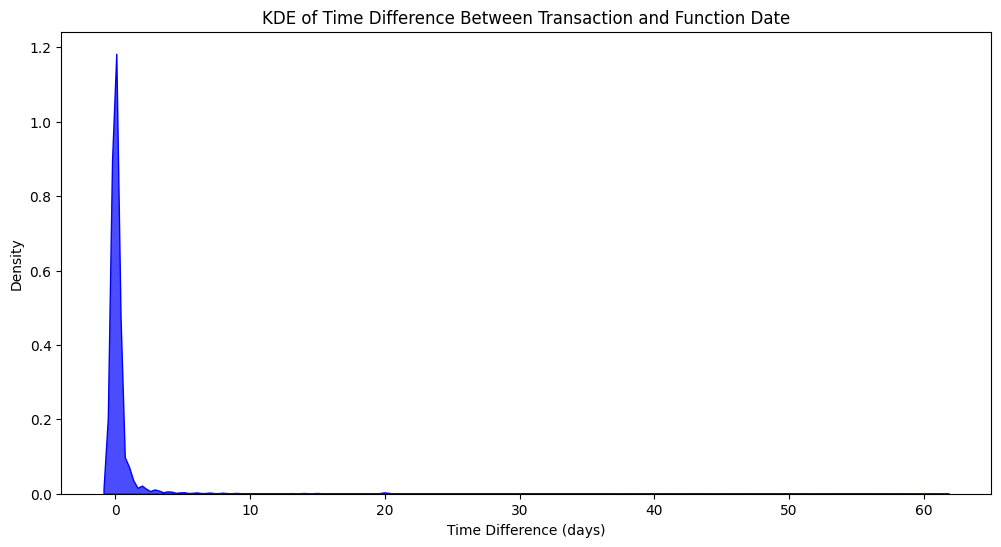

In [ ]:
# time between FECHA_TRANSACCION & FECHA_FUNCION
df_transactions['time_diff'] = (df_transactions['FECHA_FUNCION'] - df_transactions['FECHA_TRANSACCION']).dt.days

# look kde
print(f"Description of time_diff:\n{df_transactions['time_diff'].describe()}")
plt.figure(figsize=(12, 6))
sns.kdeplot(df_transactions['time_diff'], fill=True, color='blue', alpha=0.7)
plt.title('KDE of Time Difference Between Transaction and Function Date')
plt.xlabel('Time Difference (days)')
plt.ylabel('Density')

In [ ]:
# pct that are 0 days
print(f"Percentage of transactions with 0 days difference: {df_transactions['time_diff'].eq(0).mean() * 100:.2f}%")

Percentage of transactions with 0 days difference: 88.84%


---
# Users

## S1: Observed

In [ ]:
# counts
print(f"Total clients with trx: {df_transactions['CARD_MEMBERSHIPID'].nunique()}")
print(f"Total clients with emails: {df_emails['CARD_MEMBERSHIPID'].nunique()}")
print(f"Total clients with emails and trx: {df_trx_and_emailed['CARD_MEMBERSHIPID'].nunique()}") 
print(f"Avg trx per client: {df_trx_and_emailed['total_transactions'].mean():.2f}")
print(f"Avg tickets per client: {df_trx_and_emailed['total_tickets'].mean():.2f}")
print(f"Users that bought only once: {df_trx_and_emailed['total_transactions'].eq(1).mean() * 100:.2f}%")


Total clients with trx: 264155
Total clients with emails: 454740
Total clients with emails and trx: 264155
Avg trx per client: 1.22
Avg tickets per client: 2.53
Users that bought only once: 84.09%


Note:
- The database is made that only the clients that have made a transaction are included in the emails

In [ ]:
# distribution of total_transactions
df_trx_and_emailed['total_transactions'].describe()

count    264155.000000
mean          1.217467
std           0.596403
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          22.000000
Name: total_transactions, dtype: float64

---
# Sandbox

In [ ]:
df_emails

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11
...,...,...,...,...,...
478487,2024-05-04,1454286,b3e4bb24bc7a77772836a7586cde7ab1d5b6d72e2516f5...,2024-05-04 12:00:18,12
478488,2024-05-04,1454286,2d8b669ea3bdedc24eb41f49f43e843fb0eca69e8b6d0e...,2024-05-04 14:00:24,14
478489,2024-05-04,1454265,d96e76a8accd09a9e9e5f09d0ab4776176b3bc9819e074...,2024-05-04 21:00:08,21
478490,2024-05-04,1454286,4dbe45f3cac2a6d17b900c80bcf37ac8635d547796af90...,2024-05-04 14:00:20,14


In [ ]:
df_transactions

,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA
0,2ed9514e-4598-5a3a-b7eb-d3b71a312a07,903,2024-01-01,2024-01-01,246dcfe746f73242e3dc0ee6e1dff6ff169aae464c7af6...,7,AQUAMAN Y EL REINO PERDIDO,10,600.0
1,d8d32bdc-16d9-564c-a8ee-87125e669e33,355,2024-01-01,2024-01-01,d6de2ddad687c1471b307825bbaf6a5b54ca4ff8dfaab8...,1,EL NIÑO Y LA GARZA,5,450.0
2,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0
3,668f2c6a-af11-5552-a7e7-67d33ea470d3,273,2024-01-01,2024-01-01,f180d6ee7ed2986afc41d421ed36e84ca38fd437fb3a22...,1,¡PATOS!,2,82.0
4,b55a6b51-30ad-51dd-9317-58a2bcc5e9e4,905,2024-01-01,2024-01-01,b21d81b41698f87bf8a79ebe3bf52481f728d6b2542541...,5,PRISCILLA,2,370.0
...,...,...,...,...,...,...,...,...,...
321595,f89bffcc-6fad-5a94-a897-be17cf41f27b,233,2024-07-22,2024-07-22,de0a38adfa37aef03887cedd735e968525e99449792b31...,1,MI VILLANO FAVORITO 4,2,92.0
321596,aeb6bdf8-9334-573d-a48e-b459e0980594,168,2024-07-22,2024-07-22,766e48c6a60c411dd1afef24184713b498d632d7d2deff...,1,TORNADOS,2,92.0
321597,021f45e3-b0c0-56de-92a1-05d0fb41244a,198,2024-07-22,2024-08-10,9ebae2ffb0f74fe142666207eb2df77ce91e5ec8b60df5...,1,HARRY POTTER Y LA CÁMARA SECRETA,3,282.0
321598,aec8ae74-af46-5f95-827b-d292f7116b8a,168,2024-07-22,2024-07-22,c0429640fe80a4019be0b99336e9b1752b09109a9b39e7...,1,MI VILLANO FAVORITO 4,2,92.0


In [ ]:
df_emails

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11
...,...,...,...,...,...
478487,2024-05-04,1454286,b3e4bb24bc7a77772836a7586cde7ab1d5b6d72e2516f5...,2024-05-04 12:00:18,12
478488,2024-05-04,1454286,2d8b669ea3bdedc24eb41f49f43e843fb0eca69e8b6d0e...,2024-05-04 14:00:24,14
478489,2024-05-04,1454265,d96e76a8accd09a9e9e5f09d0ab4776176b3bc9819e074...,2024-05-04 21:00:08,21
478490,2024-05-04,1454286,4dbe45f3cac2a6d17b900c80bcf37ac8635d547796af90...,2024-05-04 14:00:20,14


In [ ]:
df_emails_per_campaign

,SendId,num_emails,num_days,date_start,date_end
0,1360577,442,16,2023-10-10,2023-10-26
1,1360578,205,16,2023-10-10,2023-10-26
2,1360579,44,16,2023-10-10,2023-10-26
3,1360580,145,16,2023-10-10,2023-10-26
4,1360581,246,16,2023-10-10,2023-10-26
...,...,...,...,...,...
936,1457697,344,0,2024-07-20,2024-07-20
937,1457698,350,0,2024-07-20,2024-07-20
938,1457699,1047,0,2024-07-20,2024-07-20
939,1457700,2710,0,2024-07-20,2024-07-20


In [ ]:
df_releases

,TX_PELICULA_UNICA,ESTRENO,VENTAS
0,48HFP X EDICIÓN: GRUPO A,2024-01-13,191
1,48HFP X EDICIÓN: GRUPO B,2024-01-13,189
2,57 SEGUNDOS ATRÁS,2024-02-19,97140
3,74MICT CIELO ROJO,2024-02-14,70
4,74MICT CLUB CERO,2024-02-09,46
...,...,...,...
406,YO CAPITÁN,2024-03-07,15101
407,ZAK & WOWO,2024-04-25,10303
408,ZONA DE INTERÉS,2024-02-14,61204
409,¡PATOS!,2024-01-01,320516


In [ ]:
df_releases_range

,TX_PELICULA_UNICA,date_end,tickets_sold,money_sold,ESTRENO,VENTAS,days_on_air,blockbuster_score,date_before_release
0,57 SEGUNDOS ATRÁS,2024-03-20,1540,80344.5,2024-02-19,97140,30,16.567778,2024-02-17
1,74MICT CIELO ROJO,2024-02-14,6,198.0,2024-02-14,70,0,6.129283,2024-02-12
2,74MICT CLUB CERO,2024-02-09,3,128.0,2024-02-09,46,0,5.523562,2024-02-07
3,74MICT MONSTER,2024-02-11,6,206.0,2024-02-11,38,0,5.247928,2024-02-09
4,74MICT SOBRE HIERBAS SECAS,2024-02-13,1,50.0,2024-02-13,33,0,5.044394,2024-02-11
...,...,...,...,...,...,...,...,...,...
241,YO CAPITÁN,2024-03-20,227,17746.5,2024-03-07,15101,13,13.882356,2024-03-05
242,ZAK & WOWO,2024-05-06,160,9507.5,2024-04-25,10303,11,13.330777,2024-04-23
243,ZONA DE INTERÉS,2024-03-27,858,65847.5,2024-02-14,61204,42,15.901338,2024-02-12
244,¡PATOS!,2024-03-20,5979,299742.0,2024-01-01,320516,79,18.290037,2023-12-30


In [ ]:
df_emails

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11
...,...,...,...,...,...
478487,2024-05-04,1454286,b3e4bb24bc7a77772836a7586cde7ab1d5b6d72e2516f5...,2024-05-04 12:00:18,12
478488,2024-05-04,1454286,2d8b669ea3bdedc24eb41f49f43e843fb0eca69e8b6d0e...,2024-05-04 14:00:24,14
478489,2024-05-04,1454265,d96e76a8accd09a9e9e5f09d0ab4776176b3bc9819e074...,2024-05-04 21:00:08,21
478490,2024-05-04,1454286,4dbe45f3cac2a6d17b900c80bcf37ac8635d547796af90...,2024-05-04 14:00:20,14


In [ ]:
ts_emails

NameError: name 'ts_emails' is not defined

In [ ]:
df_transactions['FECHA_TRANSACCION'].min()

Timestamp('2024-01-01 00:00:00')

In [ ]:
df_releases_range

,TX_PELICULA_UNICA,date_end,tickets_sold,money_sold,ESTRENO,VENTAS,days_on_air,blockbuster_score,date_before_release
0,57 SEGUNDOS ATRÁS,2024-03-20,1540,80344.5,2024-02-19,97140,30,16.567778,2024-02-17
1,74MICT CIELO ROJO,2024-02-14,6,198.0,2024-02-14,70,0,6.129283,2024-02-12
2,74MICT CLUB CERO,2024-02-09,3,128.0,2024-02-09,46,0,5.523562,2024-02-07
3,74MICT MONSTER,2024-02-11,6,206.0,2024-02-11,38,0,5.247928,2024-02-09
4,74MICT SOBRE HIERBAS SECAS,2024-02-13,1,50.0,2024-02-13,33,0,5.044394,2024-02-11
...,...,...,...,...,...,...,...,...,...
241,YO CAPITÁN,2024-03-20,227,17746.5,2024-03-07,15101,13,13.882356,2024-03-05
242,ZAK & WOWO,2024-05-06,160,9507.5,2024-04-25,10303,11,13.330777,2024-04-23
243,ZONA DE INTERÉS,2024-03-27,858,65847.5,2024-02-14,61204,42,15.901338,2024-02-12
244,¡PATOS!,2024-03-20,5979,299742.0,2024-01-01,320516,79,18.290037,2023-12-30


In [ ]:
df_pricebook

,ID_CINE,PRECIO_POL_R
0,307,82.0
1,154,83.0
2,595,67.0
3,737,80.0
4,1266,51.0
...,...,...
98,936,96.0
99,673,185.0
100,514,50.0
101,395,70.0


In [279]:
df_emails

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11
...,...,...,...,...,...
478487,2024-05-04,1454286,b3e4bb24bc7a77772836a7586cde7ab1d5b6d72e2516f5...,2024-05-04 12:00:18,12
478488,2024-05-04,1454286,2d8b669ea3bdedc24eb41f49f43e843fb0eca69e8b6d0e...,2024-05-04 14:00:24,14
478489,2024-05-04,1454265,d96e76a8accd09a9e9e5f09d0ab4776176b3bc9819e074...,2024-05-04 21:00:08,21
478490,2024-05-04,1454286,4dbe45f3cac2a6d17b900c80bcf37ac8635d547796af90...,2024-05-04 14:00:20,14


In [278]:
df_customers

,CARD_MEMBERSHIPID,SubscriberKey
0,2b8e97ef50184e4ba7205b3d182e469e664594db8dbc04...,039cea23d6666fe9476d1f45478b880f564e007cf73325...
1,19d05a23131b3784beaec65a61991ab63d69543611db86...,5ac6a4ff355413bcc1a2e2649066604de3bbb2d6bb3cd8...
2,83b61b797976d6e4c01485d6e55be0cb8f2562f2fbe4d5...,8da643428f49be37a7ee7e208da6fb4bcc03f384bd84f9...
3,008a4826d2799d626fe972194d15a604503c13576715a7...,5ff176112ccc49c22096ef759ffff0f75c291f0c3360d2...
4,d1ec1403c54e306bb9013c93ab46d98eb83a3d5a3b6b0b...,b621416877fca03f0c648d2e703ba2021c3a7401a21e71...
...,...,...
5718364,0c2d31f5e477b6e55ffed867fc6e76fafd6fa1c013eba3...,74d7142db63dfc0481f7cfd825a3772d7dd0e74b4ab5a5...
5718365,4cb3953225a1079382e3ace9feb50b4d5653407284885b...,ed888499c1bba2c74c22f12809c1350827e22ebaae14a3...
5718366,f8813891cb1bc610dfce8569d04a799852af9f5296f664...,a59d4e860b78de683dd422bb5520abf453e184302fbbef...
5718367,e9924c1bb185a7bd703ca4f663db49274a717aebe46a2a...,be19517f0e29cbde98d7362f9875fdb374ec3ae37a2e51...


In [ ]:
df_trx_and_emailed

,CARD_MEMBERSHIPID,total_tickets,total_transactions,total_spent,num_emails
0,000106af97d98ed498a1e0a57abe8ef355e398a53a1cd9...,2,1,85.0,0
1,0001d0121dbac20ce03daf9e602e3d30c2b8f6af91af0b...,4,2,234.0,0
2,0001d5513d3c4ad1c33d3091dc22fbc5c7094fbf9066ed...,1,1,80.0,0
3,0002a429f0ac9ceb47bcc659efb13985fa4467f2c4e231...,2,1,92.0,0
4,0003314dbc6a79aca19aef736204b58626af7fbeaf0748...,2,1,158.0,1
...,...,...,...,...,...
264150,ffff152876de205f010d43873ec99ebf10140ce27c016e...,1,1,54.0,1
264151,ffff410ea0698ec69646c1aafa2a77701f689f0353decb...,1,1,100.0,0
264152,ffff5fda5a1e2b34873d8d60fc0931e93d199dae49c359...,2,1,144.0,0
264153,ffffac998df9587da49f9973a8b497fca19da2589d6b09...,4,2,188.0,1


In [ ]:
df_transactions

,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA
0,2ed9514e-4598-5a3a-b7eb-d3b71a312a07,903,2024-01-01,2024-01-01,246dcfe746f73242e3dc0ee6e1dff6ff169aae464c7af6...,7,AQUAMAN Y EL REINO PERDIDO,10,600.0
1,d8d32bdc-16d9-564c-a8ee-87125e669e33,355,2024-01-01,2024-01-01,d6de2ddad687c1471b307825bbaf6a5b54ca4ff8dfaab8...,1,EL NIÑO Y LA GARZA,5,450.0
2,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0
3,668f2c6a-af11-5552-a7e7-67d33ea470d3,273,2024-01-01,2024-01-01,f180d6ee7ed2986afc41d421ed36e84ca38fd437fb3a22...,1,¡PATOS!,2,82.0
4,b55a6b51-30ad-51dd-9317-58a2bcc5e9e4,905,2024-01-01,2024-01-01,b21d81b41698f87bf8a79ebe3bf52481f728d6b2542541...,5,PRISCILLA,2,370.0
...,...,...,...,...,...,...,...,...,...
321595,f89bffcc-6fad-5a94-a897-be17cf41f27b,233,2024-07-22,2024-07-22,de0a38adfa37aef03887cedd735e968525e99449792b31...,1,MI VILLANO FAVORITO 4,2,92.0
321596,aeb6bdf8-9334-573d-a48e-b459e0980594,168,2024-07-22,2024-07-22,766e48c6a60c411dd1afef24184713b498d632d7d2deff...,1,TORNADOS,2,92.0
321597,021f45e3-b0c0-56de-92a1-05d0fb41244a,198,2024-07-22,2024-08-10,9ebae2ffb0f74fe142666207eb2df77ce91e5ec8b60df5...,1,HARRY POTTER Y LA CÁMARA SECRETA,3,282.0
321598,aec8ae74-af46-5f95-827b-d292f7116b8a,168,2024-07-22,2024-07-22,c0429640fe80a4019be0b99336e9b1752b09109a9b39e7...,1,MI VILLANO FAVORITO 4,2,92.0
